<a href="https://colab.research.google.com/github/natdebandi/hate_speech_ar/blob/main/3_GPT_evaluate_bin_finetunning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP final - reconocimiento de discursos discriminatorios en Twitter

## Validación del modelo GPT 3.5 con finetning binaro

**Natalia Dedandi**

model="gpt-3.5-turbo-0125"





La documentación de la API se encuentra aqui:

https://platform.openai.com/docs/api-reference/introduction



In [1]:
pip install openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 335.9/335.9 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.9 MB/s eta 0:00:00


In [9]:
import json
from openai import OpenAI
import os
from google.colab import userdata
#seteo la KEY
os.environ['OPENAI_API_KEY'] = userdata.get('openIA_key')




In [10]:
#creo el cliente OPENAI con mi usuario y proyecto
client = OpenAI(
  organization='org-1uHjwiaB3OlPzoxfVzhqOSzs',
  project='proj_2fII7izwVGgYaERNNKhhMx4l',
)

## Recupero el modelo con finetuning binario

model="gpt-3.5-turbo-0125"

Names model:
ft:gpt-3.5-turbo-0125:personal:hate-speech-v2:9sJSTs9F



In [4]:
model_ft_bin=client.fine_tuning.jobs.retrieve('ftjob-RI7JuIvpL27w3XMLAIQWTNaw')

In [5]:
model_ft_bin

FineTuningJob(id='ftjob-RI7JuIvpL27w3XMLAIQWTNaw', created_at=1722722606, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:gpt-3.5-turbo-0125:personal:hate-speech-v2:9sJSTs9F', finished_at=1722731536, hyperparameters=Hyperparameters(n_epochs=3, batch_size=72, learning_rate_multiplier=2), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-1uHjwiaB3OlPzoxfVzhqOSzs', result_files=['file-LrrG9erjq0phdN2C09yLtKCc'], seed=112634201, status='succeeded', trained_tokens=8146536, training_file='file-Mt9HMlQtIwmiVA8R0OF4aINw', validation_file='file-bBd2qAB8YmmZUUrnkXsVO9wF', estimated_finish=None, integrations=[], user_provided_suffix='hate_speech_v2')

In [6]:

completion = client.chat.completions.create(
  model="ft:gpt-3.5-turbo-0125:personal:hate-speech-v2:9sJSTs9F",
  messages=[
    {'role': 'system', 'content': "You are trained to analyze and detect the sentiment of the given text. Only hateful or not hateful is allowed. If the text is empty or is not clear answer not hateful"},
    {"role": "user", "content": "Hay que matarlos a todos"}
  ]
)
print(completion.choices[0].message)

ChatCompletionMessage(content='hateful', role='assistant', function_call=None, tool_calls=None)


In [7]:
#result_files=['file-LrrG9erjq0phdN2C09yLtKCc']

content = client.files.content('file-LrrG9erjq0phdN2C09yLtKCc')

In [8]:
import base64
base64.b64decode(content.text.encode("utf-8"))

with open("result.csv", "wb") as f:
  f.write(base64.b64decode(content.text.encode("utf-8")))

In [9]:
# prompt: open the results csv file and put it in a dataframe

import pandas as pd
df = pd.read_csv('result.csv')


In [10]:
df


,step,train_loss,train_accuracy,valid_loss,valid_mean_token_accuracy
0,1,0.50007,0.90625,NaN,NaN
1,2,0.65534,0.88194,NaN,NaN
2,3,0.53414,0.89931,NaN,NaN
3,4,0.46418,0.92014,NaN,NaN
4,5,0.55854,0.90625,NaN,NaN
...,...,...,...,...,...
1513,1514,0.03191,0.98611,NaN,NaN
1514,1515,0.02713,0.98958,NaN,NaN
1515,1516,0.02990,0.98958,NaN,NaN
1516,1517,0.04768,0.98958,NaN,NaN


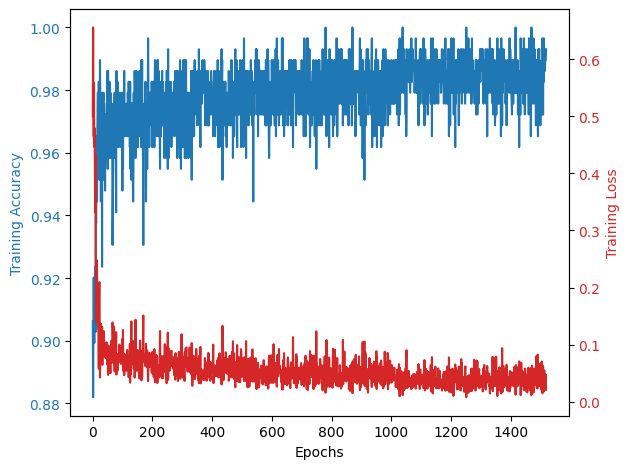

In [11]:
# prompt: graph train_accuracy and train_loss in the same graph

import matplotlib.pyplot as plt

# Extract the relevant data from the DataFrame
train_accuracy = df['train_accuracy']
train_loss = df['train_loss']
epochs = range(1, len(train_accuracy) + 1)

# Create the plot
fig, ax1 = plt.subplots()

# Plot the training accuracy
color = 'tab:blue'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Accuracy', color=color)
ax1.plot(epochs, train_accuracy, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a twin axis for the training loss
ax2 = ax1.twinx()

# Plot the training loss
color = 'tab:red'
ax2.set_ylabel('Training Loss', color=color)
ax2.plot(epochs, train_loss, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Display the plot
fig.tight_layout()
plt.show()


In [12]:
# prompt: crear una función que obtenga la última métrica de df result

def get_last_metrics(df):
  """
  Obtiene las últimas métricas del DataFrame.

  Args:
    df: El DataFrame que contiene las métricas.

  Returns:
    Un diccionario con las últimas métricas.
  """
  last_row = df.iloc[-1]
  return {
      'train_loss': last_row['train_loss'],
      'train_accuracy': last_row['train_accuracy'],
  }

# Ejemplo de uso
last_metrics = get_last_metrics(df)
print(last_metrics)


{'train_loss': 0.02103, 'train_accuracy': 0.99306}


## AHora aplico el modelo al conjunto de test para obtener todas las mérticas

In [14]:
!pip install datasets seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
     

In [1]:
from datasets import load_dataset
import pandas as pd

ds1 = load_dataset("piuba-bigdata/contextualized_hate_speech")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/36420 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11343 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/9106 [00:00<?, ? examples/s]

In [2]:
df_test = pd.DataFrame(ds1['test'])
df_test[0:5]

,id,title,text,context_tweet,HATEFUL,body,CALLS,WOMEN,LGBTI,RACISM,CLASS,POLITICS,DISABLED,APPEARANCE,CRIMINAL
0,397703,Mora Godoy cierra su escuela de tango y remata...,@usuario Ojalá se funda y cague de hambre,Mora Godoy cierra su escuela de tango y remata...,0,Puede marcar con justeza la fecha de inicio de...,0,0,0,0,0,0,0,0,0
1,397704,Mora Godoy cierra su escuela de tango y remata...,@usuario Faltó que se enganchó al hijo de sofo...,Mora Godoy cierra su escuela de tango y remata...,1,Puede marcar con justeza la fecha de inicio de...,0,1,0,0,0,0,0,0,0
2,397705,Mora Godoy cierra su escuela de tango y remata...,"@usuario y bue, que le vaya a llorar a Cristin...",Mora Godoy cierra su escuela de tango y remata...,0,Puede marcar con justeza la fecha de inicio de...,0,0,0,0,0,0,0,0,0
3,397706,Mora Godoy cierra su escuela de tango y remata...,@usuario @usuario Jodete. Macri te hizo conoce...,Mora Godoy cierra su escuela de tango y remata...,0,Puede marcar con justeza la fecha de inicio de...,0,0,0,0,0,0,0,0,0
4,397707,Mora Godoy cierra su escuela de tango y remata...,"@usuario Que se joda, es su gobierno el que el...",Mora Godoy cierra su escuela de tango y remata...,0,Puede marcar con justeza la fecha de inicio de...,0,0,0,0,0,0,0,0,0


In [7]:
# Specify the columns
id_column = 'id'
text_column = 'text'

# Convert the dataframe into a list of dictionaries with custom_id and messages
batch = [
    {
        'custom_id': str(row[id_column]),
        'method': 'POST',
        'url': '/v1/chat/completions',
        'body':{
            'model': 'ft:gpt-3.5-turbo-0125:personal:hate-speech-v2:9sJSTs9F',
            'messages': [
                {'role': 'system', 'content': "You are trained to analyze and detect the sentiment of the given text. Only hateful or not hateful is allowed. If the text is empty or is not clear answer not hateful"},
                {'role': 'user', 'content': row[text_column]}
                ],
            'max_tokens': 20,  # Limit response to a single word
            'temperature': 0  # Keep response consistent
        }
    }
    for _, row in df_test.iterrows()
]

In [8]:
import json
# Save the batch to a .jsonl file

with open('batch_gpt_bin_ft_v3.jsonl', 'w') as f:
    for entry in batch:
        json.dump(entry, f)
        f.write('\n')

print("Batch file created successfully in .jsonl format!")

Batch file created successfully in .jsonl format!


In [11]:
batch_input_file = client.files.create(
  file=open("batch_gpt_bin_ft_v3.jsonl", "rb"),
  purpose="batch"
)

In [12]:
batch_input_file

FileObject(id='file-dTTsUROQ8UerWJhLFxRdIcNr', bytes=5983670, created_at=1722807848, filename='batch_gpt_bin_ft_v3.jsonl', object='file', purpose='batch', status='processed', status_details=None)

In [13]:
batch_input_file_id = 'file-dTTsUROQ8UerWJhLFxRdIcNr'

client.batches.create(
    input_file_id=batch_input_file_id,
    endpoint="/v1/chat/completions",
    completion_window="24h",
    metadata={
      "description": "nightly eval job"
    }
)

Batch(id='batch_271qia5twF7qcZNp5AqG9T31', completion_window='24h', created_at=1722807906, endpoint='/v1/chat/completions', input_file_id='file-dTTsUROQ8UerWJhLFxRdIcNr', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1722894306, failed_at=None, finalizing_at=None, in_progress_at=None, metadata={'description': 'nightly eval job'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0))

In [14]:
client.batches.retrieve('batch_271qia5twF7qcZNp5AqG9T31')

Batch(id='batch_271qia5twF7qcZNp5AqG9T31', completion_window='24h', created_at=1722807906, endpoint='/v1/chat/completions', input_file_id='file-dTTsUROQ8UerWJhLFxRdIcNr', object='batch', status='in_progress', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1722894306, failed_at=None, finalizing_at=None, in_progress_at=1722807912, metadata={'description': 'nightly eval job'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=11343))